**Requirements:**
- `plots/[model_name]/architecture.py` should contain the model class (this is to encode individual run's architectures.
- Model checkpoints should be in: `model_checkpoint/[model_name]/` (done automatically)
- Loss files should be in: `plots/[model_name]/[model_name]_loss.npz` (done automatically)

In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import seaborn as sns
from shearnet.core.dataset import generate_dataset
from shearnet.core.train import train_model
from shearnet import EnhancedGalaxyNN
import jax.random as random
import jax.numpy as jnp
import numpy as np
import optax
import os
from dataclasses import dataclass
from typing import List, Optional
import sys
import importlib.util

from flax.training import checkpoints, train_state
from shearnet.utils.metrics import eval_model, eval_ngmix, eval_mcal
from shearnet.utils.plot_helpers import (
    plot_residuals, 
    visualize_samples, 
    plot_true_vs_predicted, 
    animate_model_epochs
)
from shearnet.utils.notebook_output_system import (
    log_print, save_plot, log_array_stats, experiment_section, get_output_manager
)

@dataclass
class ModelConfig:
    """Configuration for a ShearNet model to compare"""
    name: str  # Display name for plots
    model_dir_prefix: str  # Directory prefix to search for (e.g., 'cnn1', 'cnn2')
    color: str  # Color for plots
    marker: str = 'o'  # Marker style for scatter plots

def load_model_and_evaluate(model_config, rng_key, test_images, test_labels, base_checkpoint_path, base_data_path):
    """Load a model and evaluate it using its saved architecture"""
    
    # Path to the saved architecture file
    arch_file = os.path.join(base_data_path, "plots", model_config.model_dir_prefix, "architecture.py")
    
    if not os.path.exists(arch_file):
        raise FileNotFoundError(f"Architecture file not found: {arch_file}")
    
    print(f"Loading architecture from: {arch_file}")
    
    # Dynamically import the architecture module
    spec = importlib.util.spec_from_file_location(f"{model_config.model_dir_prefix}_arch", arch_file)
    arch_module = importlib.util.module_from_spec(spec)
    sys.modules[f"{model_config.model_dir_prefix}_arch"] = arch_module
    spec.loader.exec_module(arch_module)
    
    # Try to find the model class in the architecture module
    model_class_names = ['ResearchBackedGalaxyResNet', 'OriginalGalaxyNN', 'EnhancedGalaxyNN', 'GalaxyResNet']
    model_class = None
    
    for class_name in model_class_names:
        if hasattr(arch_module, class_name):
            model_class = getattr(arch_module, class_name)
            print(f"Found model class: {class_name}")
            break
    
    if model_class is None:
        # Fallback: list all classes in the module
        available_classes = [name for name in dir(arch_module) 
                           if isinstance(getattr(arch_module, name), type) 
                           and name != 'Module']
        
        if available_classes:
            model_class = getattr(arch_module, available_classes[0])
            print(f"Using first available class: {available_classes[0]}")
        else:
            raise ValueError(f"No model class found in {arch_file}")
    
    # Create model instance and get correctly shaped test images
    model = model_class()
    init_params, actual_test_images = _adaptive_model_init(model, rng_key, test_images, model_config.name)
    state = train_state.TrainState.create(
        apply_fn=model.apply, params=init_params, tx=optax.adam(1e-3)
    )
    
    # Find matching checkpoint directory
    matching_dirs = []
    for d in os.listdir(base_checkpoint_path):
        if os.path.isdir(os.path.join(base_checkpoint_path, d)):
            # Exact prefix match to avoid false matches
            if d.startswith(model_config.model_dir_prefix):
                # Make sure it's not a longer prefix
                rest = d[len(model_config.model_dir_prefix):]
                if rest == "" or rest[0].isdigit():
                    matching_dirs.append(d)
    
    print(f"Found {len(matching_dirs)} matching directories for {model_config.name}: {matching_dirs}")
    
    if not matching_dirs:
        raise FileNotFoundError(f"No directory found for {model_config.name} with prefix: {model_config.model_dir_prefix}")
    
    # Use the latest directory if multiple found
    model_dir = os.path.join(base_checkpoint_path, sorted(matching_dirs)[-1])
    print(f"Loading {model_config.name} from: {model_dir}")
    
    # Restore checkpoint
    state = checkpoints.restore_checkpoint(ckpt_dir=model_dir, target=state)
    
    # Evaluate with the correctly shaped test images
    results = eval_model(state, actual_test_images, test_labels)
    return results

def _adaptive_model_init(model, rng_key, test_images, model_name):
    """
    Try different input shapes to initialize the model correctly.
    Returns (init_params, correctly_shaped_test_images)
    """
    print(f"Test images shape: {test_images.shape}")
    
    # Strategy 1: Try PSF-style initialization first (4D with 2 channels)
    if test_images.ndim == 4 and test_images.shape[-1] == 2:
        try:
            print(f"Trying PSF initialization for {model_name}: (1, {test_images.shape[1]}, {test_images.shape[2]}, 2)")
            init_input = jnp.ones((1, test_images.shape[1], test_images.shape[2], 2))
            init_params = model.init(rng_key, init_input)
            print(f"✓ PSF initialization successful for {model_name}")
            return init_params, test_images
        except Exception as e:
            print(f"PSF initialization failed: {e}")
    
    # Strategy 2: Try original 3D initialization
    try:
        print(f"Trying original initialization for {model_name}: (1, {test_images.shape[1]}, {test_images.shape[2]})")
        if test_images.ndim == 4:
            # Convert 4D to 3D by taking first channel
            test_images_3d = test_images[:, :, :, 0]
        else:
            test_images_3d = test_images
        
        init_input = jnp.ones((1, test_images_3d.shape[1], test_images_3d.shape[2]))
        init_params = model.init(rng_key, init_input)
        print(f"✓ Original initialization successful for {model_name}")
        return init_params, test_images_3d
    except Exception as e:
        print(f"Original initialization failed: {e}")
    
    # Strategy 3: Try 4D with 1 channel
    try:
        print(f"Trying 4D single-channel initialization for {model_name}")
        if test_images.ndim == 4:
            test_images_4d_single = test_images[:, :, :, :1]
        else:
            test_images_4d_single = jnp.expand_dims(test_images, axis=-1)
        
        init_input = jnp.ones((1, test_images_4d_single.shape[1], test_images_4d_single.shape[2], 1))
        init_params = model.init(rng_key, init_input)
        print(f"✓ 4D single-channel initialization successful for {model_name}")
        return init_params, test_images_4d_single
    except Exception as e:
        print(f"4D single-channel initialization failed: {e}")
    
    raise ValueError(f"Could not initialize model {model_name} with any input format")

In [2]:
# ========================================================================================
# CONFIGURATION: MODIFY THIS TO SET UP YOUR COMPARISON
# ========================================================================================

# Define the models you want to compare
model_configs = [
    ModelConfig(
        name="Research ResNet",
        model_dir_prefix="research_backed_galaxy_resnet",
        color="blue", 
        marker="s"
    ),
    ModelConfig(
        name="Research ResNet with PSF",
        model_dir_prefix="research_backed_low_noise_with_psf",
        color="yellow",
        marker="^"
    ),

    # Add more models as needed
]

# Set whether to include NGMix comparison
include_ngmix = False  # Set to False if you don't want NGMix comparison

# Print configuration
log_print("="*50)
log_print("BENCHMARK CONFIGURATION")
log_print("="*50)
log_print(f"Models to compare: {[config.name for config in model_configs]}")
log_print(f"Include NGMix: {include_ngmix}")
log_print("="*50)

DEBUG: Current working directory: /home/adfield/ShearNet_Dev/notebooks
DEBUG: Found 'notebooks' in current path
DEBUG: Attempting to create directory: /home/adfield/ShearNet_Dev/notebooks/out
DEBUG: Directory created/exists: /home/adfield/ShearNet_Dev/notebooks/out
DEBUG: Directory is writable: True
DEBUG: Created new output file: /home/adfield/ShearNet_Dev/notebooks/out/out.md
ShearNet Output Manager initialized:
  Output directory: /home/adfield/ShearNet_Dev/notebooks/out
  Output file: /home/adfield/ShearNet_Dev/notebooks/out/out.md
  Directory exists: True
  Can write to directory: True
BENCHMARK CONFIGURATION
Models to compare: ['Research ResNet', 'Research ResNet with PSF']
Include NGMix: False


In [ ]:
with experiment_section("Test Dataset Generation"):
    rng_key = random.PRNGKey(42)
    test_images, test_labels, test_obs = generate_dataset(5000, 0.25, npix=53, scale=0.141, type='gauss', exp='ideal', nse_sd=1e-3, seed=42, return_obs=True)
    # CONTROL NOISE WITH ", nse_sd=_____" THIS DEFAULTS TO 1e-5
    
    log_print(f"Generated {len(test_images)} test samples")
    log_print(f"Image shape: {test_images.shape}")
    log_print(f"Labels shape: {test_labels.shape}")
    
    # Log some array statistics
    log_array_stats("test_images", test_images)
    log_array_stats("test_labels", test_labels)

Test Dataset Generation
DEBUG: Logged to file: /home/adfield/ShearNet_Dev/notebooks/out/out.md


  0%|          | 0/5000 [00:00<?, ?it/s]

Learning Curves Comparison
DEBUG: Logged to file: /home/adfield/ShearNet_Dev/notebooks/out/out.md
Research ResNet:
  Final training loss: 0.000006
  Final validation loss: 0.000011
  Best validation loss: 0.000011 at epoch 290
  Total epochs: 300
Research ResNet with PSF:
  Final training loss: 0.000003
  Final validation loss: 0.000009
  Best validation loss: 0.000009 at epoch 300
  Total epochs: 300
DEBUG: Attempting to save plot to: /home/adfield/ShearNet_Dev/notebooks/out/learning_curves_comparison_20250704_005440.png
SUCCESS: Plot saved to /home/adfield/ShearNet_Dev/notebooks/out/learning_curves_comparison_20250704_005440.png (size: 512086 bytes)
![learning_curves_comparison_20250704_005440.png](learning_curves_comparison_20250704_005440.png)


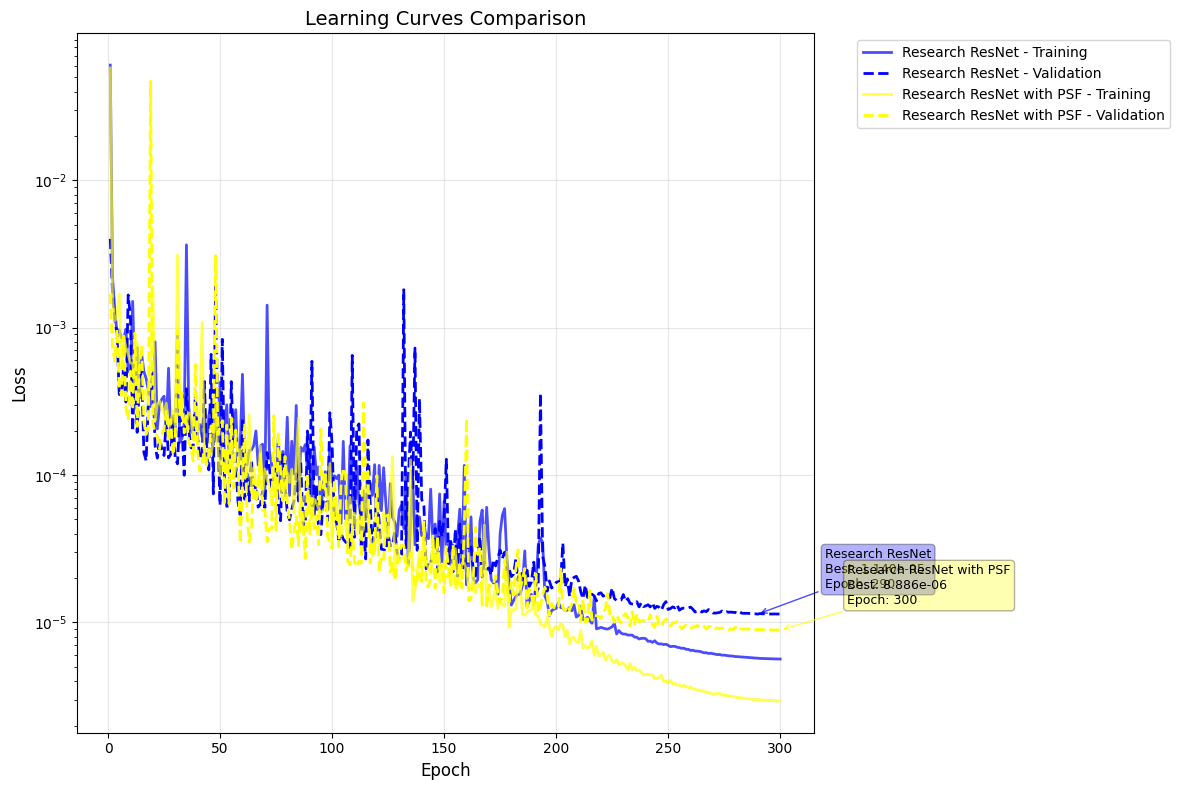

---


In [4]:
with experiment_section("Learning Curves Comparison"):
    base_data_path = os.getenv('SHEARNET_DATA_PATH', os.path.abspath('.'))

    # Create the plot
    plt.figure(figsize=(12, 8))

    for config in model_configs:
        # Load loss data for this model
        loss_file = os.path.join(base_data_path, "plots", config.model_dir_prefix, f"{config.model_dir_prefix}_loss.npz")
        
        if os.path.exists(loss_file):
            loss = np.load(loss_file)
            train_loss = loss['train_loss']
            val_loss = loss['val_loss']
            
            epochs = np.arange(1, len(train_loss) + 1)
            
            # Plot with model-specific colors
            plt.plot(epochs, train_loss, color=config.color, linestyle='-', 
                    label=f'{config.name} - Training', linewidth=2, alpha=0.7)
            plt.plot(epochs, val_loss, color=config.color, linestyle='--', 
                    label=f'{config.name} - Validation', linewidth=2)
            
            # Add annotations for best validation loss
            best_val_epoch = np.argmin(val_loss) + 1
            best_val_loss = np.min(val_loss)
            plt.annotate(f'{config.name}\nBest: {best_val_loss:.3e}\nEpoch: {best_val_epoch}',
                        xy=(best_val_epoch, best_val_loss), 
                        xytext=(best_val_epoch + len(epochs)*0.1, best_val_loss * 1.5),
                        arrowprops=dict(arrowstyle='->', color=config.color, alpha=0.7),
                        fontsize=9,
                        bbox=dict(boxstyle="round,pad=0.3", facecolor=config.color, alpha=0.3))
            
            # Log statistics
            log_print(f"{config.name}:")
            log_print(f"  Final training loss: {train_loss[-1]:.6f}")
            log_print(f"  Final validation loss: {val_loss[-1]:.6f}") 
            log_print(f"  Best validation loss: {best_val_loss:.6f} at epoch {best_val_epoch}")
            log_print(f"  Total epochs: {len(train_loss)}")
        else:
            log_print(f"Warning: Loss file not found for {config.name}: {loss_file}")

    plt.yscale("log")
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title('Learning Curves Comparison', fontsize=14)
    plt.legend(fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    # Save plot and show
    save_plot("learning_curves_comparison.png")
    plt.show()

In [5]:
with experiment_section("Model Loading and Evaluation"):
    base_checkpoint_path = os.path.join(base_data_path, "model_checkpoint")

    # Dictionary to store all results
    all_results = {}

    # Evaluate each ShearNet model
    for model_config in model_configs:
        log_print(f"\nEvaluating {model_config.name}...")
        results = load_model_and_evaluate(model_config, rng_key, test_images, test_labels, base_checkpoint_path, base_data_path)
        all_results[model_config.name] = {
            'preds': results["all_preds"],
            'config': model_config,
            'type': 'shearnet'
        }

    # Evaluate NGMix if requested
    if include_ngmix:
        log_print(f"\nEvaluating NGMix...")
        ngmix_results = eval_ngmix(test_obs, test_labels, seed=1234)
        all_results['NGMix'] = {
            'preds': ngmix_results["preds"],
            'config': None,
            'type': 'ngmix'
        }

    log_print(f"\nAll evaluations complete! Models: {list(all_results.keys())}")

Model Loading and Evaluation
DEBUG: Logged to file: /home/adfield/ShearNet_Dev/notebooks/out/out.md

Evaluating Research ResNet...
Loading architecture from: /home/adfield/ShearNet_Dev/plots/research_backed_galaxy_resnet/architecture.py
Found model class: ResearchBackedGalaxyResNet
Test images shape: (5000, 53, 53, 2)
Trying PSF initialization for Research ResNet: (1, 53, 53, 2)
PSF initialization failed: Expected input with 3 dimensions (batch_size, height, width), got (1, 53, 53, 2)
Trying original initialization for Research ResNet: (1, 53, 53)
Flattened shape: (1, 96)
✓ Original initialization successful for Research ResNet
Found 1 matching directories for Research ResNet: ['research_backed_galaxy_resnet300']
Loading Research ResNet from: /home/adfield/ShearNet_Dev/model_checkpoint/research_backed_galaxy_resnet300
Flattened shape: (32, 96)
Flattened shape: (32, 96)


2025-07-04 00:54:51.213534: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.


Flattened shape: (8, 96)
Flattened shape: (8, 96)

=== Combined Metrics (ShearNet) ===
Mean Squared Error (MSE) from ShearNet: 5.426312e-04
Average Bias from ShearNet: -7.045391e-03
Time taken: 6.16 seconds

=== Per-Label Metrics ===
             g1: MSE = 8.961392e-04, Bias = -2.833925e-02
             g2: MSE = 3.250619e-04, Bias = -7.286874e-03
  g1g2_combined: MSE = 6.106006e-04, Bias = -1.781306e-02
          sigma: MSE = 1.682576e-04, Bias = +8.483884e-03
           flux: MSE = 7.810651e-04, Bias = -1.039317e-03


Evaluating Research ResNet with PSF...
Loading architecture from: /home/adfield/ShearNet_Dev/plots/research_backed_low_noise_with_psf/architecture.py
Found model class: ResearchBackedGalaxyResNet
Test images shape: (5000, 53, 53, 2)
Trying PSF initialization for Research ResNet with PSF: (1, 53, 53, 2)
PSF initialization failed: Expected input with 3 dimensions (batch_size, height, width), got (1, 53, 53, 2)
Trying original initialization for Research ResNet with PSF: (

ScopeParamShapeError: Initializer expected to generate shape (3, 3, 2, 16) but got shape (3, 3, 1, 16) instead for parameter "kernel" in "/Conv_0". (https://flax.readthedocs.io/en/latest/api_reference/flax.errors.html#flax.errors.ScopeParamShapeError)

In [8]:
with experiment_section("Model Evaluation Summary"):
    # True values
    g1_true = test_labels[:, 0]
    g2_true = test_labels[:, 1]  
    sigma_true = test_labels[:, 2]
    flux_true = test_labels[:, 3]

    # Print summary statistics for all models
    log_print("="*60)
    log_print("EVALUATION SUMMARY", level="SUBHEADER")
    log_print("="*60)

    for model_name, result in all_results.items():
        preds = result['preds']
        log_print(f"\n{model_name}:")
        for i, param in enumerate(["g1", "g2", "sigma", "flux"]):
            true_vals = test_labels[:, i]
            pred_vals = preds[:, i]
            rmse = np.sqrt(np.mean((pred_vals - true_vals)**2))
            bias = np.mean(pred_vals - true_vals)
            log_print(f"  {param:5s}: RMSE = {rmse:.6f}, Bias = {bias:.6f}")

    log_print(f"\nReady for plotting with {len(all_results)} models")

Model Evaluation Summary
DEBUG: Logged to file: /home/adfield/ShearNet_Dev/notebooks/out/out.md
EVALUATION SUMMARY

Research ResNet:
  g1   : RMSE = 0.010554, Bias = 0.000221
  g2   : RMSE = 0.010670, Bias = 0.000142
  sigma: RMSE = 0.008499, Bias = -0.000127
  flux : RMSE = 0.023772, Bias = -0.000368

Control:
  g1   : RMSE = 0.012341, Bias = 0.000392
  g2   : RMSE = 0.012673, Bias = -0.002512
  sigma: RMSE = 0.012440, Bias = 0.000743
  flux : RMSE = 0.029450, Bias = -0.005277

Ready for plotting with 2 models
---


Prediction Comparison Plots
DEBUG: Logged to file: /home/adfield/ShearNet_Dev/notebooks/out/out.md
DEBUG: Attempting to save plot to: /home/adfield/ShearNet_Dev/notebooks/out/prediction_comparison_20250702_192242.png
SUCCESS: Plot saved to /home/adfield/ShearNet_Dev/notebooks/out/prediction_comparison_20250702_192242.png (size: 1221421 bytes)
![prediction_comparison_20250702_192242.png](prediction_comparison_20250702_192242.png)


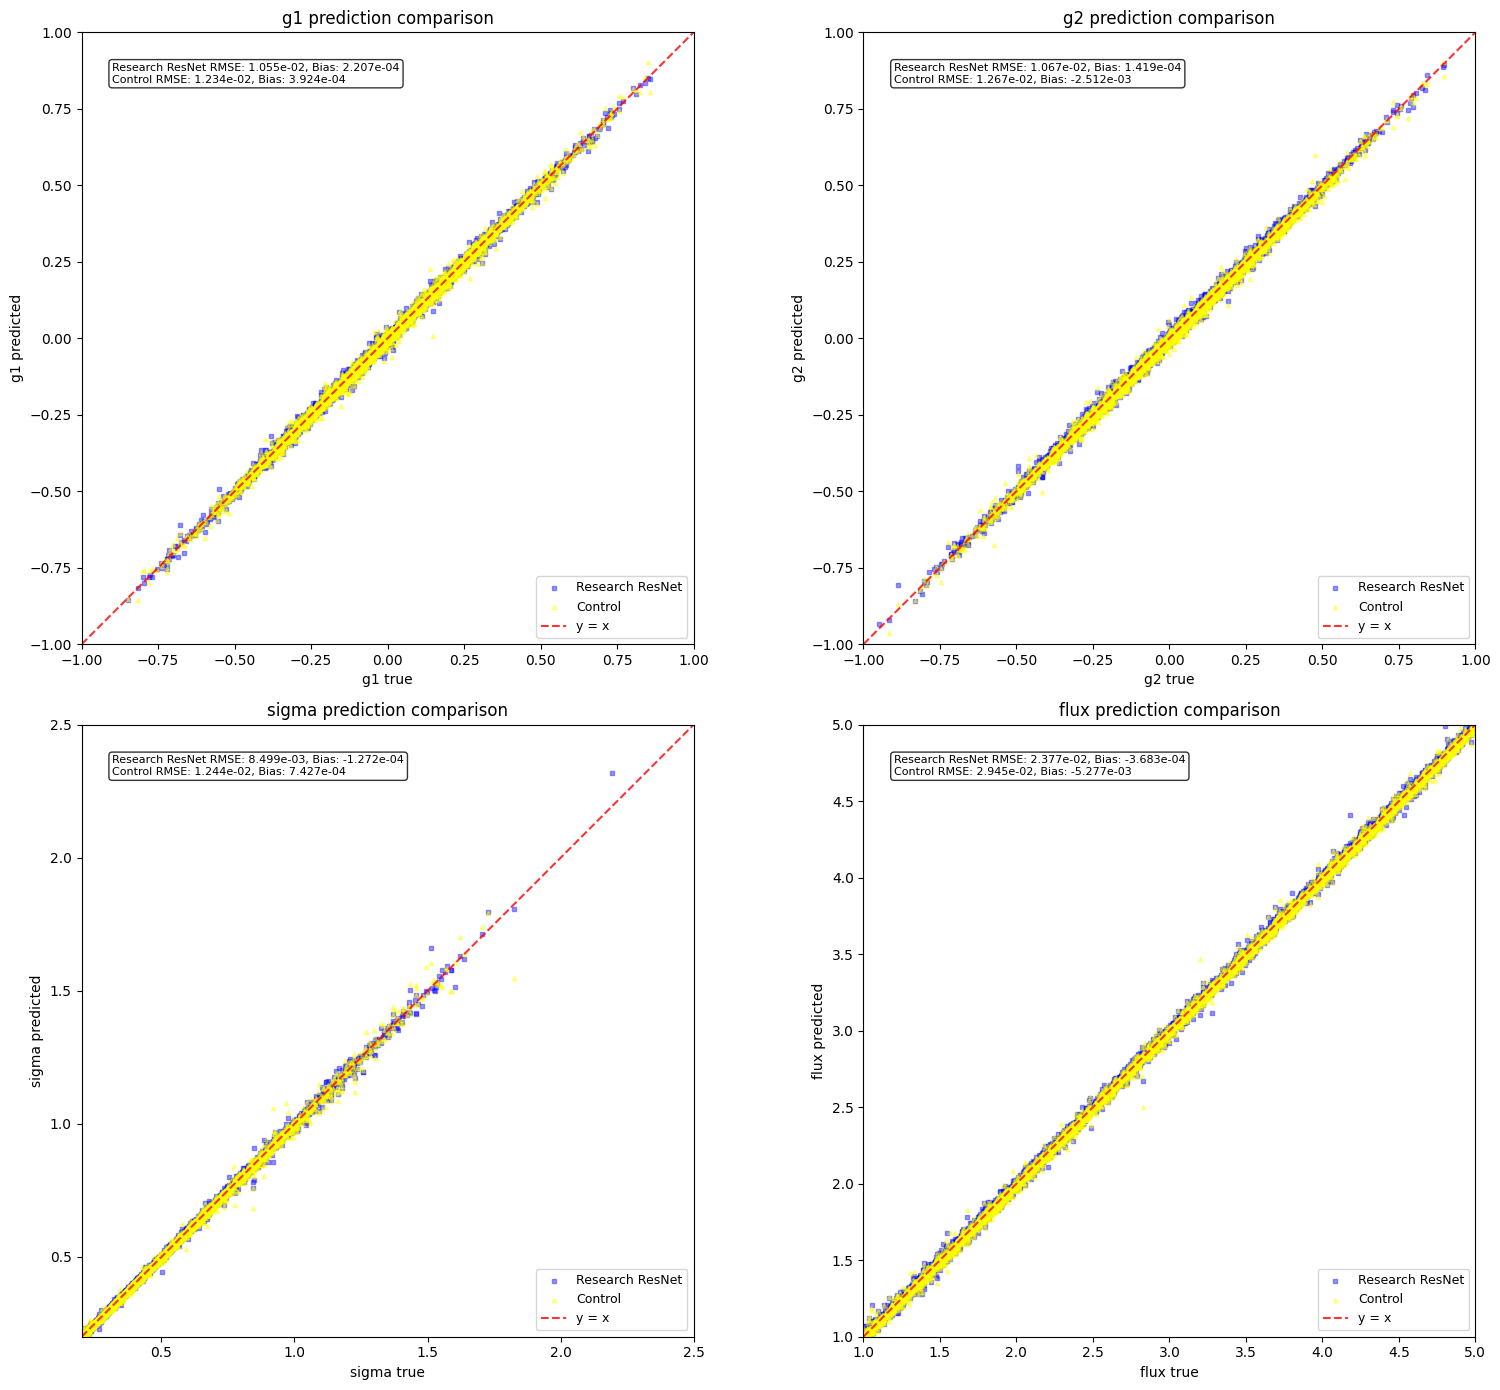

---


In [9]:
with experiment_section("Prediction Comparison Plots"):
    # Set up plot
    fig, axs = plt.subplots(2, 2, figsize=(16, 14))

    quantities = [
        ("g1", g1_true, -1., 1.),
        ("g2", g2_true, -1., 1.),
        ("sigma", sigma_true, 0.2, 2.5),
        ("flux", flux_true, 1, 5.)
    ]

    for ax, (name, true_vals, vmin, vmax) in zip(axs.flat, quantities):
        param_idx = ["g1", "g2", "sigma", "flux"].index(name)
        
        # Plot each model's predictions
        for model_name, result in all_results.items():
            preds = result['preds'][:, param_idx]
            
            if result['type'] == 'ngmix':
                color = 'green'
                marker = '^'
                label = model_name
            else:
                color = result['config'].color
                marker = result['config'].marker
                label = model_name
            
            ax.scatter(true_vals, preds, alpha=0.4, label=label, s=10, 
                      color=color, marker=marker)
        
        # Reference line
        ax.plot([vmin, vmax], [vmin, vmax], 'r--', label='y = x', alpha=0.8)
        
        # Axes formatting
        ax.set_xlim(vmin, vmax)
        ax.set_ylim(vmin, vmax)
        ax.set_aspect('equal', adjustable='box')
        ax.set_xlabel(f"{name} true")
        ax.set_ylabel(f"{name} predicted")
        ax.set_title(f"{name} prediction comparison")

        # Calculate and display metrics
        metrics_text = ""
        for model_name, result in all_results.items():
            preds = result['preds'][:, param_idx]
            rmse = np.sqrt(np.mean((preds - true_vals)**2))
            bias = np.mean(preds - true_vals)
            metrics_text += f"{model_name} RMSE: {rmse:.3e}, Bias: {bias:.3e}\n"

        ax.text(0.05, 0.95, metrics_text.strip(),
                transform=ax.transAxes, fontsize=8,
                verticalalignment='top',
                bbox=dict(boxstyle="round", facecolor="white", alpha=0.8))

        ax.legend(fontsize=9)

    plt.tight_layout()
    
    # Save plot and show
    save_plot("prediction_comparison.png")
    plt.show()

Residuals Comparison Plots
DEBUG: Logged to file: /home/adfield/ShearNet_Dev/notebooks/out/out.md
DEBUG: Attempting to save plot to: /home/adfield/ShearNet_Dev/notebooks/out/residuals_comparison_20250702_192253.png
SUCCESS: Plot saved to /home/adfield/ShearNet_Dev/notebooks/out/residuals_comparison_20250702_192253.png (size: 304525 bytes)
![residuals_comparison_20250702_192253.png](residuals_comparison_20250702_192253.png)


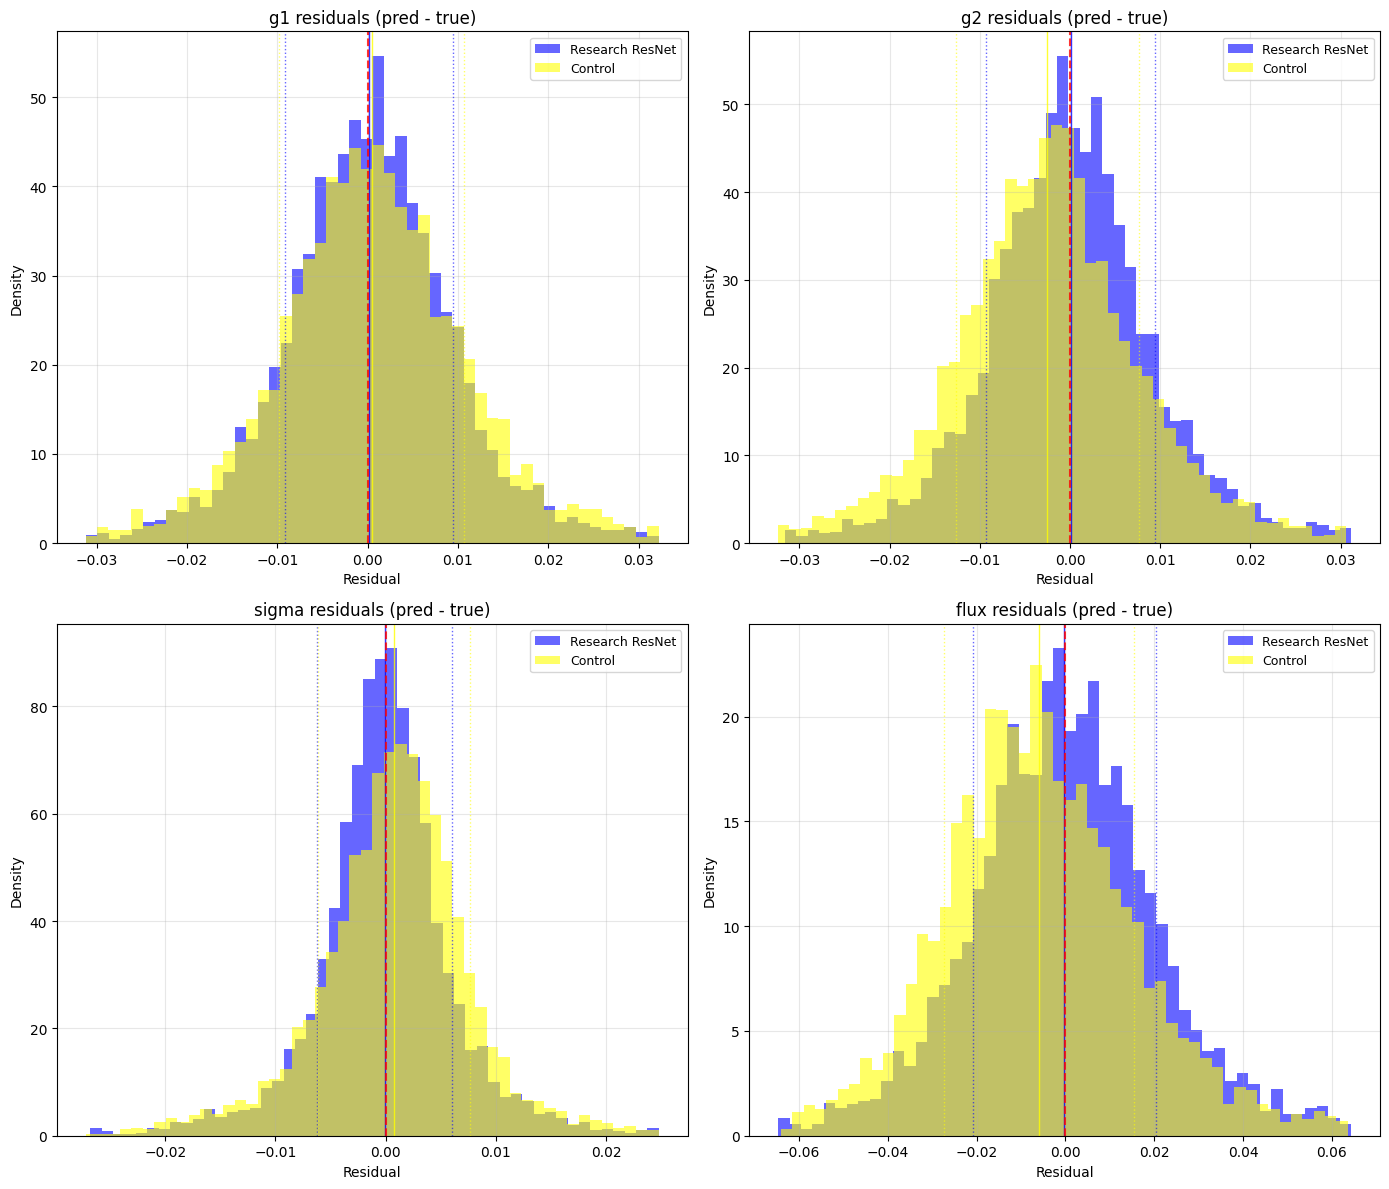

---
Multi-model benchmark complete!
DEBUG: Logged to file: /home/adfield/ShearNet_Dev/notebooks/out/out.md


In [10]:
with experiment_section("Residuals Comparison Plots"):
    # Compute residuals for all models
    residuals_data = {}
    for model_name, result in all_results.items():
        preds = result['preds']
        residuals_data[model_name] = {
            "g1": preds[:, 0] - test_labels[:, 0],
            "g2": preds[:, 1] - test_labels[:, 1], 
            "sigma": preds[:, 2] - test_labels[:, 2],
            "flux": preds[:, 3] - test_labels[:, 3],
            "result": result
        }

    fig, axs = plt.subplots(2, 2, figsize=(14, 12))
    bins = 50

    for ax, param in zip(axs.flat, ["g1", "g2", "sigma", "flux"]):
        # Collect all residuals for this parameter to determine clipping
        all_residuals = []
        for model_name, model_residuals in residuals_data.items():
            all_residuals.extend(model_residuals[param])
        
        # Clip extremes to focus on the bulk distribution
        clip_min = np.percentile(all_residuals, 1)
        clip_max = np.percentile(all_residuals, 99)

        # Plot histograms for each model
        for model_name, model_residuals in residuals_data.items():
            residuals = model_residuals[param]
            result = model_residuals["result"]
            
            # Clip residuals
            residuals_clipped = residuals[(residuals >= clip_min) & (residuals <= clip_max)]
            
            if result['type'] == 'ngmix':
                color = 'green'
                label = model_name
            else:
                color = result['config'].color
                label = model_name
            
            ax.hist(residuals_clipped, bins=bins, alpha=0.6, label=label, 
                   color=color, density=True)
            
            # Add mean ± std lines
            mean = np.mean(residuals_clipped)
            std = np.std(residuals_clipped)
            ax.axvline(mean, color=color, linestyle='-', linewidth=1, alpha=0.8)
            ax.axvline(mean + std, color=color, linestyle=':', linewidth=1, alpha=0.6)
            ax.axvline(mean - std, color=color, linestyle=':', linewidth=1, alpha=0.6)
        
        ax.axvline(0, color='red', linestyle='--', alpha=0.8)
        
        # Labels
        ax.set_title(f"{param} residuals (pred - true)")
        ax.set_xlabel("Residual")
        ax.set_ylabel("Density")
        ax.legend(fontsize=9)
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    
    # Save plot and show
    save_plot("residuals_comparison.png")
    plt.show()

log_print("Multi-model benchmark complete!", level="HEADER")